# Detecting fake news, and limiting spread of misinformation using Naive Bayes

This notebook aims to identify fake news from amidst a pool of news articles. The data is divided into two samples, real and fake. Thus, both sources indicating what are the pre-classified values in the news headlines/articles.

Source: https://www.uvic.ca/ecs/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf?utm_medium=redirect&utm_source=/engineering/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf&utm_campaign=redirect-usage

More about the source: The data has been gathered from real-world sources, specifically from reuters.com for real news articles. Fake news articles have been gathered from non-recognizable third party sources, which are largely unreliable. The dataset has been fact checked for fake/real by a US based organziation called Politifact as well as Wikipedia. Topics covered in these are mainly world politics and world news

Citations: 
1. Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text 
classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, 
January/February 2018.

2. Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram 
Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) 
Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. 
ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-
138)


## 1.1 Load libraries

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import nltk
from textblob import TextBlob
import pandas as pd
import sklearn
import _pickle as cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
nltk.download('punkt')
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Load data, investigate information within the dataset

In [90]:
#read the data
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

In [91]:
#brief data description
fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [92]:
#brief data description
real.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


Above we notice that there are 23,481entries in the fake dataset, interestingly it has repeats, which is why unique counts are lesser. Another interesting fact is that title and text have different unique counts.

In [93]:
#Add a status column for real or fake news
fake['status'] = "fake"
real['status'] = "real"

#Add length counters for title and news article
fake['title_length'] = fake['title'].str.len()
real['title_length'] = real['title'].str.len()

fake['text_length'] = fake['text'].str.len()
real['text_length'] = real['text'].str.len()

In [94]:
#Concatenate data into a single database before data processing for training
news = pd.concat([real,fake])

#Shuffle the rows in the data randomly
news = news.sample(frac=1, random_state=0)
news = news.reset_index(drop=True)
news.head()

,title,text,subject,date,status,title_length,text_length
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",fake,84,1611
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",fake,85,3039
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",fake,76,2132
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",fake,76,2948
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",real,62,1481


In [95]:
#Check if there are any NA values which need replacement
news.isna().sum()

title           0
text            0
subject         0
date            0
status          0
title_length    0
text_length     0
dtype: int64

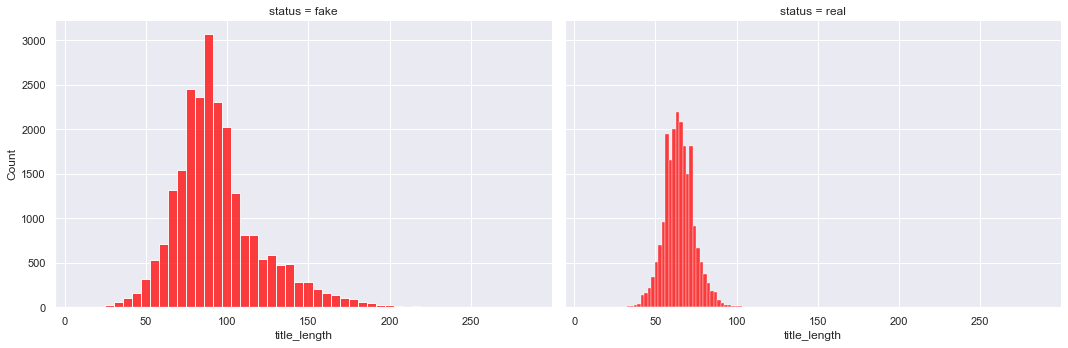

In [96]:
#Plot histogram to see how length of news/title matters w.r.t fake or real
sns.set(style="darkgrid")
hist_plot = sns.FacetGrid(data=news, col='status', col_wrap=2, height=5, aspect=1.5)
hist_plot.map(sns.histplot, 'title_length', color = 'red', bins = 50)

What is interesting from the above, is that real news seems to have less verbose titles. Likely because fake news would require more creative fabircation to make it seem fake. However this is just speculation, but stil interesting

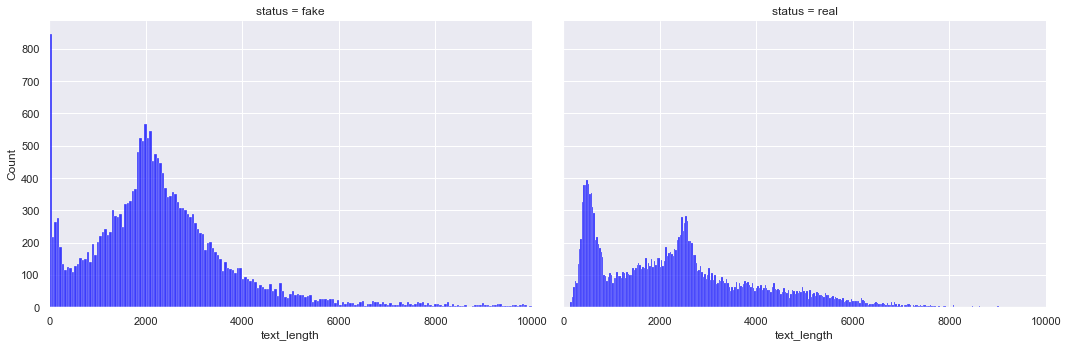

In [223]:
#Plot histogram to see how length of news matters w.r.t fake or real
hist_plot = sns.FacetGrid(data=news, col='status', col_wrap=2, height=5, aspect=1.5)
hist_plot.set(xlim=(0, 10000))
hist_plot.map(sns.histplot, 'text_length', color = 'blue', bins = 1000)

We see something very similar in the above charts as well, depicting the length of the news. Fake news overall seems to around 2000 words, however that does not seem to be the obvious case in real news, which is more often shorter. Again, likely could be due to the same explanation as given above

C:\Users\mohit\AppData\Local\Temp/ipykernel_6416/4025774297.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(subplot.get_xticklabels(), rotation=90)
C:\Users\mohit\AppData\Local\Temp/ipykernel_6416/4025774297.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


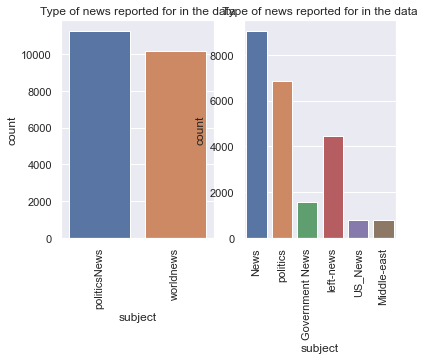

In [98]:
#Let's inspect the type of news being reported in each of the real and fake news datasets
fig, ax = plt.subplots(1,2)
for subplot in ax:
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=90)
    subplot.set_title("Type of news reported for in the data")
    
sns.countplot(data = real, x = 'subject', ax = ax[0])
sns.countplot(data = fake, x = 'subject', ax = ax[1])
fig.show()

What you see above on the left is for real news, and right is fake news. It might seem fake news has more categories, but one key detail here is that those subjects are as good as "worldnews" combined if you add each of them up

## 1.3 Process data for Naive Bayes

In [99]:
#Import packages needed to perform tokenization, lemmatization and data cleaning (stop words removal)
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

p_stemming = PorterStemmer()
stop_words = set(stopwords.words("english"))

# set the random seed, for reproducibility
np.random.seed(523)

In [100]:
#View the data
news.head()

,title,text,subject,date,status,title_length,text_length
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",fake,84,1611
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",fake,85,3039
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",fake,76,2132
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",fake,76,2948
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",real,62,1481


In [101]:
#Clean the data from the source, by removing capitalization, removing punctuations, and cutting down stop words
def clean_news(x):
    
    x = re.sub('[^a-z\s]', '', x.lower())                  
    x = [w for w in x.split() if w not in set(stop_words)] 
        
    return ' '.join(x)# remove stopwords

%time news['clean_title'] = news['title'].apply(clean_news)
%time news['clean_text'] = news['text'].apply(clean_news)

Wall time: 3.1 s
Wall time: 1min 25s


In [102]:
#Converting the news to tokens, transforming to stems and performing lemmatization
def lemmas(news):
    
    #Transforming each word in the cell contents to a single token
    tokens = word_tokenize(news)
    
    #Identifying stemsfrom tokens 
    stems = []
    for word in tokens:
        stems.append(p_stemming.stem(word))

    #Lemmatization for stemmed words
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in stems:
        lemmas.append(wordnet_lemmatizer.lemmatize(word))
        
    return lemmas

In [104]:
#Converting the cleaned text to lemmatized forms, to see how the data changes
%time news['lemm_title'] = news['clean_title'].apply(lambda x: lemmas(x))
%time news['lemm_text'] = news['clean_text'].apply(lambda x: lemmas(x))

Wall time: 43.2 s
Wall time: 14min 10s


In [105]:
news.head()

,title,text,subject,date,status,title_length,text_length,clean_title,clean_text,lemm_title,lemm_text
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",fake,84,1611,rubio sides democrats giving whopping billion ...,democrats want spend whopping billion zika vir...,"[rubio, side, democrat, give, whop, billion, z...","[democrat, want, spend, whop, billion, zika, v..."
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",fake,85,3039,ted cruz says endorsing trump grave mistake pr...,republican presidential candidate texas senato...,"[ted, cruz, say, endors, trump, grave, mistak,...","[republican, presidenti, candid, texa, senat, ..."
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",fake,76,2132,responsible gun owner road rages threatens sho...,national rifle association tells us need ensur...,"[respons, gun, owner, road, rage, threaten, sh...","[nation, rifl, associ, tell, u, need, ensur, s..."
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",fake,76,2948,teachers union protest gets ugly protesters co...,case live midwest might noticed fight continue...,"[teacher, union, protest, get, ugli, protest, ...","[case, live, midwest, might, notic, fight, con..."
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",real,62,1481,etihad advises checks us missions new trump order,dubai reuters etihad airways advising passenge...,"[etihad, advis, check, u, mission, new, trump,...","[dubai, reuter, etihad, airway, advis, passeng..."


In [106]:
#Let's compare how the original title has now changed to the processed title
print(news['lemm_title'][2])
print(news['title'][2])

['respons', 'gun', 'owner', 'road', 'rage', 'threaten', 'shoot', 'motorcyclist', 'video']
 ‘Responsible Gun Owner’ Road Rages, Threatens To Shoot Motorcyclist (VIDEO)


We can see clearly, how each word has been split seperately, also you may notice that the first output makes no sense. This is because we removed stopwords, capitalizations and punctuation marks, so that the training process is not interfered by words characters which may not have enough utility in training our model

## 1.4 Use tfidf scores to convert each word into machine understandable language, call algorithm functions to use

In [224]:
#Import required libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

### 1.4.1 TF_IDF transformation for title

In [172]:
#Transforming the entire bag of words in the news headline to TF_IDF scores
tfidf = TfidfVectorizer(lowercase=False, stop_words='english')
%time title_tfidf = tfidf.fit_transform(news['clean_title'])

Wall time: 1.63 s


### 1.4.2 TF_IDF transformation for text

In [173]:
#Transforming the entire bag of words in the news text to TF_IDF scores
%time text_tfidf = tfidf.fit_transform(news['clean_text'])

Wall time: 24.2 s


## 1.5 Train, test, model

### 1.5.1 Tinker parameters: Use news headline

In [174]:
#Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
np.random.seed(342)

In [175]:
#Assign news text to split for training and testing
x_head = title_tfidf
y_head = news['status']

In [176]:
#80% training and 20% testing split
x_head_train, x_head_test, y_head_train, y_head_test = train_test_split(x_head, y_head, test_size=0.2, random_state= 777)

#### 1.5.1.1 Use Naive Bayes on headline

In [197]:
#Passing the training data prepared from tfidf scores for headline for Naive Bayes
model_naive = MultinomialNB().fit(x_head_train, y_head_train)
prediction_naive = model_naive.predict(x_head_test)
print(classification_report(prediction_naive,y_head_test))

              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      4868
        real       0.92      0.94      0.93      4112

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



Thus we see, we are getting an accuracy of 94% from the model

In [193]:
#Observing the confusion matrix outputs, to see performance
confusion_matrix(y_head_test, prediction_naive)

array([[4528,  230],
       [ 340, 3882]], dtype=int64)

Text(0.5, 0, 'predicted label')

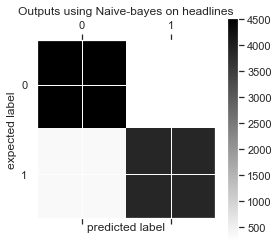

In [194]:
#Visualizing confusion matrix for prediction outputs
plt.matshow(confusion_matrix(y_head_test, prediction_naive), cmap=plt.cm.binary, interpolation='nearest')
plt.title('Outputs using Naive-bayes on headlines')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

#### 1.5.1.2 Use SVC on headline

In [198]:
#Passing the training data prepared from tfidf scores for headline for SVC
model_svc = LinearSVC().fit(x_head_train, y_head_train)
prediction_svc = model_svc.predict(x_head_test)
print(classification_report(prediction_svc,y_head_test))

              precision    recall  f1-score   support

        fake       0.95      0.96      0.96      4728
        real       0.96      0.95      0.95      4252

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



Thus we see, we are getting an accuracy of 95% from the model

In [225]:
#Observing the confusion matrix outputs, to see performance
confusion_matrix(y_head_test, prediction_svc)

array([[4740,   18],
       [  23, 4199]], dtype=int64)

Text(0.5, 0, 'predicted label')

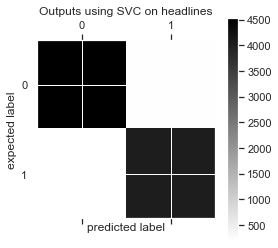

In [201]:
#Visualizing confusion matrix for prediction outputs
plt.matshow(confusion_matrix(y_head_test, prediction_svc), cmap=plt.cm.binary, interpolation='nearest')
plt.title('Outputs using SVC on headlines')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

### 1.5.2 Tinker parameters: Use news content

Checking if accuracy changes if we replace headline with the actual news story, which is way larger in data size

In [226]:
#Assign news text to split for training and testing
x_cont = text_tfidf
y_cont = news['status']

In [227]:
#80% training and 20% testing split
x_cont_train, x_cont_test, y_cont_train, y_cont_test = train_test_split(x_cont, y_cont, test_size=0.2, random_state= 777)

#### 1.5.2.1 Use Naive Bayes on news content

In [228]:
#Passing the training data prepared from tfidf scores for news content for Naive Bayes
model_naive_cont = MultinomialNB().fit(x_cont_train, y_cont_train)
prediction_naive_cont = model_naive_cont.predict(x_cont_test)
print(classification_report(prediction_naive_cont,y_cont_test))

              precision    recall  f1-score   support

        fake       0.93      0.96      0.95      4590
        real       0.96      0.92      0.94      4390

    accuracy                           0.94      8980
   macro avg       0.95      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



Interestingly, even with more data points from news content, the accuracy using Naive Bayes remains around 94%

In [208]:
#Observing the confusion matrix outputs, to see performance
confusion_matrix(y_cont_test, prediction_naive_cont)

array([[4424,  334],
       [ 166, 4056]], dtype=int64)

Text(0.5, 0, 'predicted label')

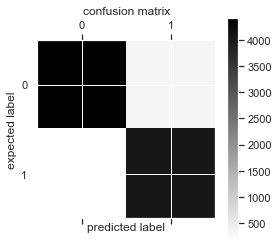

In [210]:
#Visualizing confusion matrix for prediction outputs
plt.matshow(confusion_matrix(y_cont_test, prediction_naive_cont), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

#### 1.5.2.2 Use svc on news content

In [214]:
#Passing the training data prepared from tfidf scores for headline for SVC
model_svc_cont = LinearSVC().fit(x_cont_train, y_cont_train)
prediction_svc_cont = model_svc_cont.predict(x_cont_test)
print(classification_report(prediction_svc_cont,y_cont_test))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4763
        real       0.99      1.00      1.00      4217

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



We see a very strong performance by the model using SVC with aditional dtaa points from the news article content, at almost 99%+

In [215]:
#Observing the confusion matrix outputs, to see performance
confusion_matrix(y_cont_test, prediction_svc_cont)

array([[4740,   18],
       [  23, 4199]], dtype=int64)

Text(0.5, 0, 'predicted label')

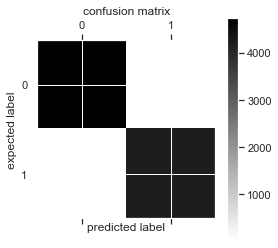

In [216]:
#Visualizing confusion matrix for prediction outputs
plt.matshow(confusion_matrix(y_cont_test, prediction_svc_cont), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

### 1.5.3 Tinker parameters: Performing n fold cross validation

#### 1.5.3.1 Use cross validation for naive bayes on both kind of news data

In [219]:
#With naive bayes and headline
%time scores = cross_val_score(MultinomialNB(), x_head_train, y_head_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

Wall time: 2.74 s
[0.9373608  0.93415924 0.93708241 0.93108729 0.93568147]
0.9350742418919703 0.0022962062643596473


In [220]:
#With naive bayes and content
%time scores = cross_val_score(MultinomialNB(), x_cont_train, y_cont_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

Wall time: 4.56 s
[0.94292873 0.93889198 0.94084076 0.94194626 0.94765418]
0.9424523830858991 0.0029262804142036023


Scores after cross validation remain consistently around 93 - 94% for headline data and 94-95% for news content, indicating that there may not be over fitting with little variation in accuracy with change in test/train data

#### 1.5.3.2 Use cross validation for svc on both kind of news data

In [221]:
#With svc and headline
%time scores = cross_val_score(LinearSVC(), x_head_train, y_head_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

Wall time: 790 ms
[0.94724388 0.9451559  0.94418151 0.94473061 0.94556592]
0.9453755650482595 0.0010408447036632084


In [222]:
#With svc and news content
%time scores = cross_val_score(LinearSVC(), x_cont_train, y_cont_train, cv=5, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

Wall time: 1.99 s
[0.99457127 0.99415367 0.99484967 0.9952666  0.99596269]
0.9949607803254839 0.0006185197577646521


Scores after cross validation remain consistently around 94 - 95% for headline data and 99-100% for news content, indicating that there may not be over fitting with little variation in accuracy with change in test/train data

### Answer prompts

**1. Describe the dataset you chose. Why did you choose it? What features does it include? What year is it from? How was it collected? What should we know about this dataset as we read your writeup? (4pts)**

A. The source for this dataset has been cited above with source link. 

This data has been gathered from real world newspapers. The source for real news was reuters.com a well renowned news publishing organization. While fake news was a collection from largely known unreliable sources which have been fact checked by PolitiFact and Wikipedia. PolitiFact being an organization dedicated to fact checking in the USA.

I chose this dataset because I wanted to explore the relationship between fake news and the content within. Fake news datasets are plentifully available, however I chose this one because it collected fake news from multiple sources, so there was a less chance for bias from a particular source to come in. Real news being collected just from Reuters was concerning, but the fact that it is from a reputable source is encouraging.

This data contains features such as the news title, the news article itself, subject it belongs to and the date when it was published.

All the articles come from the year 2016-2017. As mentioned above, all of the real news is from Reuters, and fake news is flagged by PolitiFact and Wikipedia. In total there are over 12k articles in this dataset.

One thing to know about this dataset is that originally the data for real and fake news is separate, and there was pre-processing and random shuffling to do on the data before running it for training and testing.

**2. Define a research question. What are you trying to predict? Describe what you're trying to accomplish (it will differ between Supervised and Unsupervised learning). (4pts)**

A. The research question is as follows - To verify and classify if any piece of news is real or fake based on its headline. 

The main idea to accomplish is to fit a model which can effectively work on new unseen data and predict if it should be believed or be cautious about. Fake news has been the story of the decade, specifically with social media blow ups, and the people learning about several political campaigns using this as a weapon. Fake news continuously hurts society and in my opinion is highly unethical. 

Which is why I am using supervised learning techniques like SVC and Naive Bayes to weed through past data which has been classified as fake/real and better predict how new news needs to be perceived by the public. As part of this process, I am feeding pre-decided classifications for news article to the model, allowing a model to learn to distinguish between real and fake news, and then predicting. This learning method is called supervised learning

**3. Why is this algorithm a good way of answering your research question? (2pts)**

A. Naive bayes and SVC are powerful algorithms for performing natural language processing applications such as spam filtering, sentiment analysis, misinformation prediction etc. A key reason why this works is due to the number of variables we need to work with in this problem. Each unique word is its own variable, hence Naïve Bayes and SVC work well in such situations, unlike others which may be more prone to overfitting. Additionally, these algorithms work better with categorical data compared to others for classification and are even faster in operation.

**4. Using the data you chose and the algorithm you chose, read in your data and run your model. (6pts)**

A. Done as per the code above.

**5. Tinker with parameters at least 3 times (changing learning rate, changing features, changing k like in KNN, etc). You may tinker with the same kind of parameter 3 times, it doesn't have to be 3 different parameters. (example: you can just tinker with k. k=1, k=3, or k=8) Or you might want to tinker with features and also your k value or whatever is appropriate for your algorithm. (3pts)**

A. Based on the codes above, I have used two features. First being the news headline, to identify if that feature is enough to get adequately accurate results on test. Second being the news content, which is more voluminous in data, hence more than enough to get a greater accuracy in predictions, however it severely loses out on time peformance. Lastly, I have also tried a 5-cross validation to see how with different test and training sampls within the dataset, the outputs of the model vary.

**6. Report the accuracy of your model. Either through RMSE or another metric. How did accuracy change with your parameter tinkering? (3pts)**

A. The accuracy of the model, as reported in the code above can be seen below:
    1. First, we use headline data:
        a. If we use Naive Bayes, accuracy is ~93-94%, which is respectable given that the headline has less data contents
        b. If we use SVC, accuracy is also pretty good at ~94-95%%. 
    2. If we use news content for training the model:
        a. With Naive bayes, accuracy does not improve too much, despite the volume of data. It goes stays a bit constant. Thus, it provides a very slight improvement
        b. With SVC however, it switches performance up further and goes up to almost 100%, with only a few cases incorrectly classified.
    3. Lastly, the cross validation gives confidence such that there is strong accuracy across the board with multiple train/test samples. Thus, showing lesser chances of overfitting for the model despite the selection of training or testing data

**7. Create a visualization demonstrating your findings. Make sure to include a title and axis labels. Describe what's being shown in your visualization. (3pts)**

A. There are two kind of visualizations in this workbook, one is before the model is developed:
    1. Length of the title and news v/s fake or real news counts. From the visualizations two kind of patterns are visible. Real news is more often seen with shorter titles and even shorter news stories. However fake news seems to have longer sentences for titles and news. A speculation - this could be because to make fake news seem more genuine, the authors compensate by writing extra (purely inferenced)
    2. Second we see visualziation of what category of news is present in the dataset. Real news on the left seems to be having two categories news/politics almost equallty divided. Since fake news is from multiple soruces, we see regional news as a subject, but overall even this data set has a similar distribution of news and politics.
    3. Lastly, after running the algorithm, I have also plotted a confusion matrix indicating how true positive, true negative, false positive and false negative is distributed. We observe overall, because the accuracies of Naive Bayes and SVC are 95%+, the confusion matrix plot looks very dark for true positive and true negative, and almost white for the false outputs. This is desirable and indicates the model is performing well

**8. What challenges did you run into? Do you think it was because of the data, the model, the research question? How would you overcome these challenges? (4pts)**

A. One of the biggest challenges I ran into was with the variations in outputs depending on which data I picked, and a simultaneous output of the algorithms. Picking larger data sets in this instance should be more useful since more data means more features and more context for the algorithms to learn if news is fake or not. However, there is a huge computational requirement, which is a tradeoff. There may be potential ways to reduce processing time, which was a challenge to me, but I was unable to address it fully. 

Now, if we say we want faster processing, it made sense to go ahead with fake news detection just based on the news headline. As it still provides more than enough accuracy to the test data. However, here if we just used headlines, naive bayes gave a 94% accuracy, which is still good, and improves with SVC as well for lager news article data.

To overcome these challenges, I would first try to work on the computational issues, by optimizing the code further, writing better programs which do not require multiple runs of this algorithm so this notebook can execute faster. I already tried this to some extent by realizing I needed to remove some repetitive functions and store the final TF_IDF scores in a variable instead of re-running this every time. I could try to convert the data types from dataframe to a numpy array for faster processing, however I chose ease of use in this case and did not correct it for now. Secondly, I would work on the pre-processing of the data further and try out more alternative versions of the dataset, to see if there were certain biases which caused.

**9. We learned a little bit about how our models can affect real people in the world. Name 2 potential benefits of your model and 2 potential harms. You can even look at the Wikipedia page on Algorithmic Bias (Links to an external site.) for inspiration. Every model has consequences, what can you think of? If your data is really not amenable to this question, simply write about any other example we covered in class, such as the Boston housing dataset or hate speech detectors. (6pts)**
A. Machine learning models are daily impacting real world. Much like them all, I expect models like the fake news prediction to have significant impacts on society. 
Some potential benefits:
1.	Informs people, makes them more vigilant about questioning the data they consume rather than accept blind truth. Thus, allowing them to make better decisions based on the news they consume
2.	Can help if any entity is trying to destabilize society by swaying opinions, throwing light at notorious fake news spreaders 
3.	This model can also help a lot of organizations to filter unwanted content, to keep users more engaged to new applications or social media by showing them genuine content instead of distracting garbage content
Some harms:
1.	The model can only be as good as the data. I have accepted the data as it is and claimed that Reuters is the most reliable source and thus, I am rejecting any other style of writing and claiming them to be fake. This can create a dangerous precedence of censorship and also introduces lots of bias from one source
2.	Prediction errors, although from this model are less, can still occur. Thus, it cannot be fully trusted and needs to be accepted with a grain of salt. Else it can potentially flag false positive/false negatives which will give a false sense of security to the reader
Some dangerous consequences as a result of this model can be:
1.	Over-simplification and generalization of news sources. Because the model is biased to claim Reuters style news writing to be real, it might claim other genuine one’s fake. Thus introducing a weight power dynamic where everything favors Reuters in the future. Similar can be said about several other machine learning problems like Boston data, where little consideration on why house prices were associate with such a history was taken. The numbers may not lie, but it is actually the data you use which forces the numbers to lie. It can increase the divide between parties, preventing free speech, open competition which pushes people to innovate.
2.	This model can be used by notorious users for immoral uses, where they can manipulate and systematically create echo chambers, thus just reinforcing people’s ignorant opinions further. This can be dangerous and be used as a political weapon for several use cases. (A recent example being the 2016 US elections, and more recently the war in Ukraine)

**10. Name one research question you might ask next for future work (don't worry, you don't have to do it!) Why is it important? (2pts)**

A. For future work, I would like to explore this line of thinking to a project more relevant to real world scenarios. I'd like to scrape data from the most curent events, and see if I can predict on real/near-real time if the news is real or fake. One example being identifying if news on the current war in Ukraine is real or fake propoganda from parties.
I would also like to operationalize this as a tool for people to verify such information quickly, via tweets if possible since that is where so much audience lies. It is important to let people get unbiased and real information so they can choose for themselves who they want to support and be with, otherwise we are heading to a damgerous time where people can be manipulated for unwanted outcomes
